In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib.animation as animation
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

from sklearn.datasets import make_blobs


# from mpl_toolkits.mplot3d import Axes3D

In [2]:
seed = 1337
np.random.seed(seed)

<IPython.core.display.Javascript object>


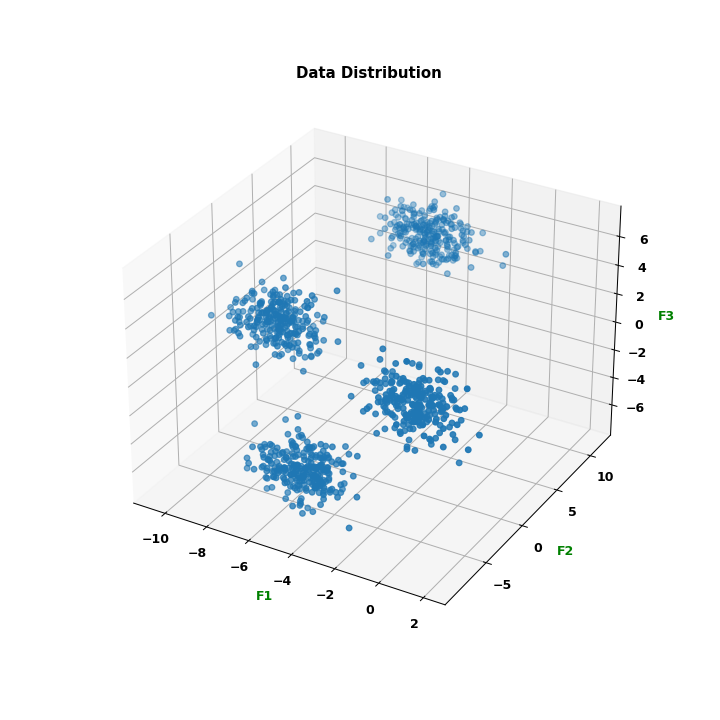

In [3]:
X, y = make_blobs(n_samples=1000, centers=4, n_features=3,
...                   random_state=seed)

df = pd.DataFrame(X)
df.rename(columns={0:'f1',1:'f2',2:'f3'},inplace=True)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df['f1'], 
    df['f2'], 
    df['f3']
)

ax.set_title('Data Distribution')
ax.set_xlabel('F1', c='g')
ax.set_ylabel('F2', c='g')
ax.set_zlabel('F3', c='g');


# One Class SVM

In [4]:
def displayScatter(df, title='no title provided', classCol = 'class',):
    fig = plt.figure(figsize=[8,8])
    ax = plt.axes(projection='3d')

    
    # plt.scatter(df[df['class']==-1]['f1'], df[df['class']==-1]['f2'],c='b',alpha=0.5)
    # plt.scatter(df[df['class']==1]['f1'], df[df['class']==1]['f2'],c='r',alpha=0.5)
    # plt.title(title);

    ax.scatter(
        df[df['class']==1]['f1'], 
        df[df['class']==1]['f2'], 
        df[df['class']==1]['f3'],
        c='r',
        alpha = 0.6,
    )
    ax.scatter(
        df[df['class']==-1]['f1'], 
        df[df['class']==-1]['f2'], 
        df[df['class']==-1]['f3'],
        c='b',
        alpha = 0.2,
        marker="v"
    )
    ax.set_title(title)
    ax.set_xlabel('F1', c= 'g')    
    ax.set_ylabel('F2', c= 'g')    
    ax.set_zlabel('F3', c= 'g');

<IPython.core.display.Javascript object>


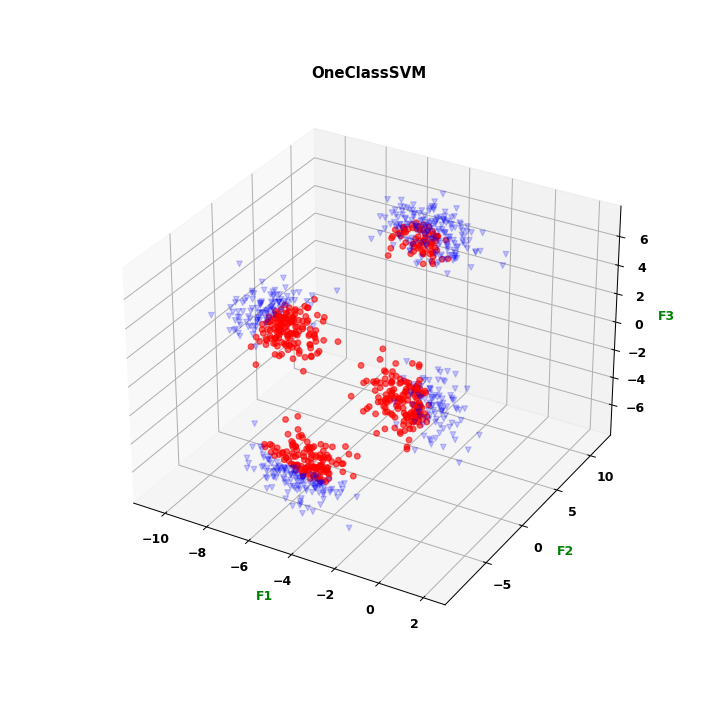

In [5]:
df['class'] = OneClassSVM().fit_predict(df)
displayScatter(df,'OneClassSVM')

# One Class SVM SGD

<IPython.core.display.Javascript object>


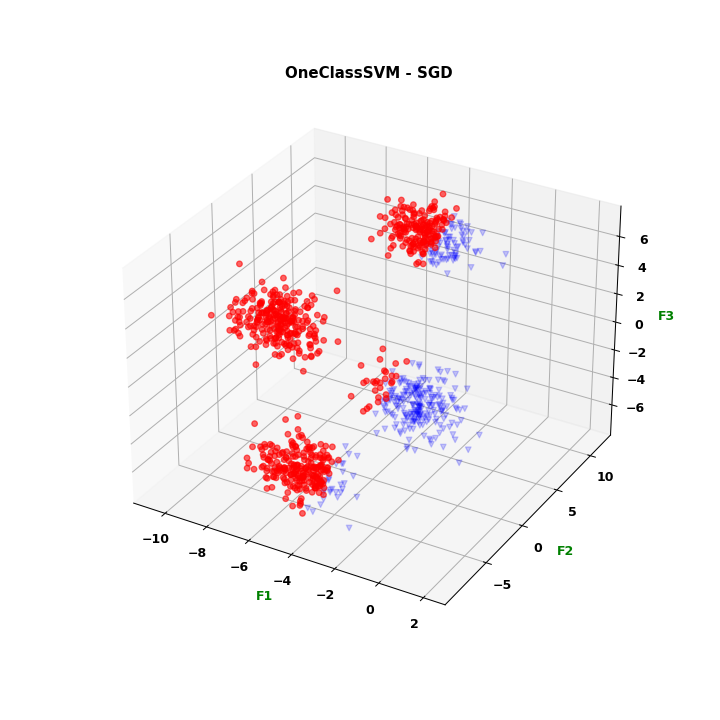

In [6]:
df['class'] = SGDOneClassSVM().fit_predict(df)

displayScatter(df,'OneClassSVM - SGD')

# Isolation Forest

<IPython.core.display.Javascript object>


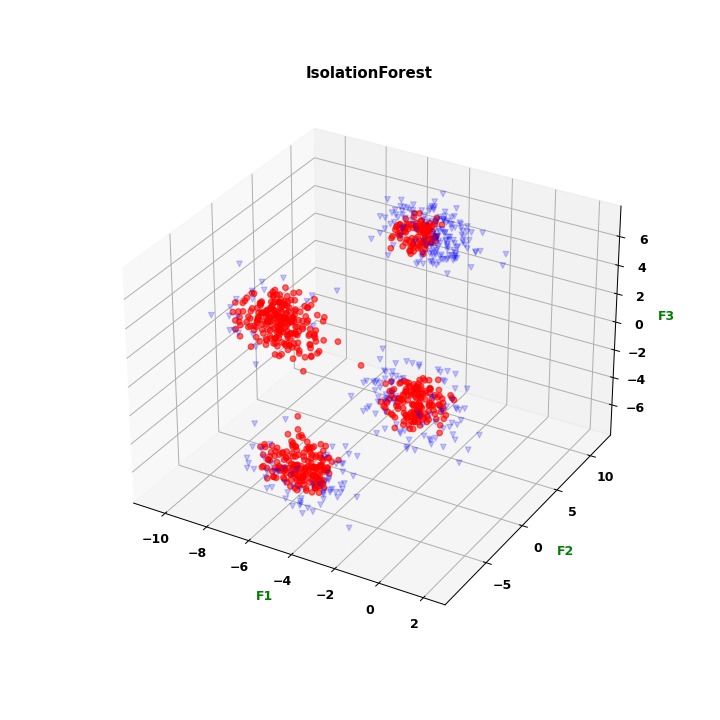

In [7]:
df['class'] = IsolationForest().fit_predict(df)

displayScatter(df,'IsolationForest')

# Local Outlier Factor

<IPython.core.display.Javascript object>


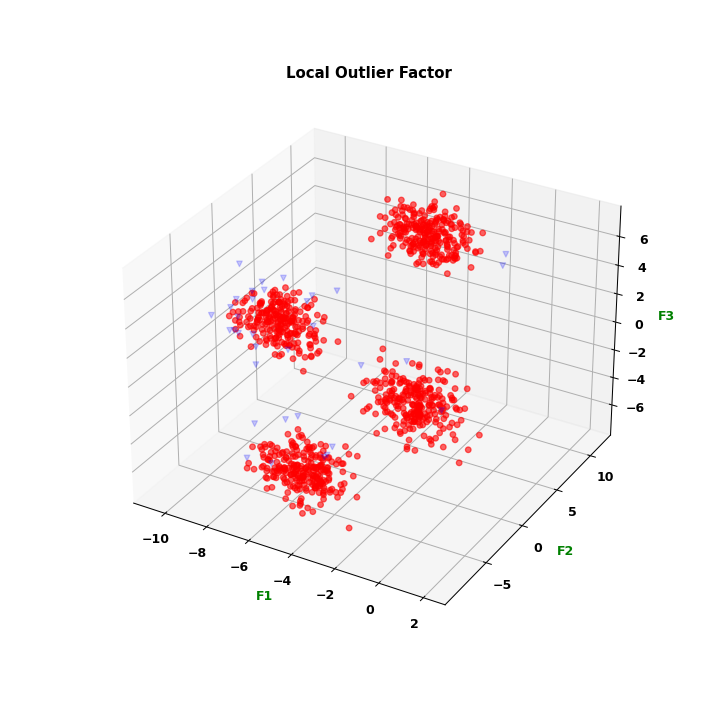

In [8]:
lof = LocalOutlierFactor()
df['class'] = lof.fit_predict(df)

displayScatter(df,'Local Outlier Factor')

# KMeans

<IPython.core.display.Javascript object>


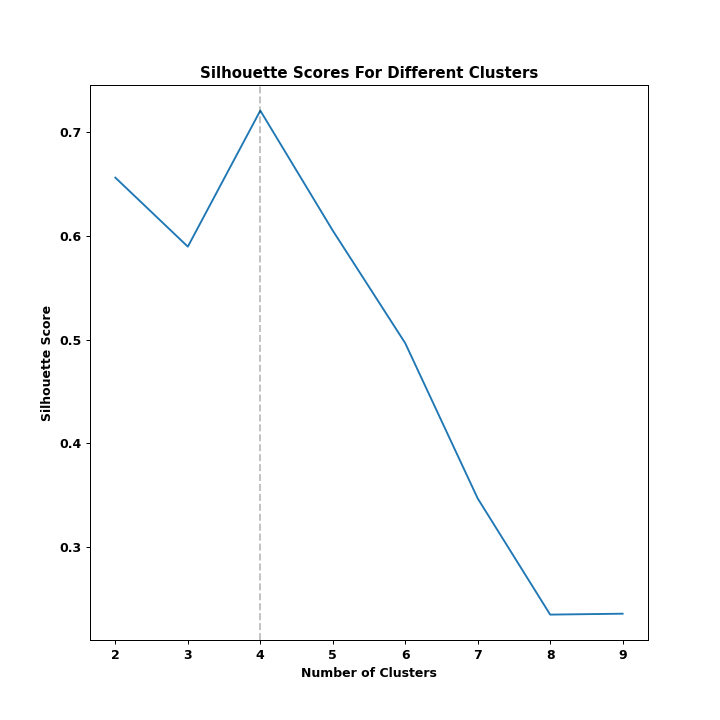

In [19]:
kmeans_df = df[['f1','f2','f3']].copy()

silhouette_scores = {}
max_score_cluster = {'n':0, 'score':0}

for i in range (2,10):
    k = KMeans(n_clusters=i)
    k.fit(kmeans_df)
    sc = silhouette_score(kmeans_df, k.labels_)
    
    silhouette_scores[i] = sc
    
    if sc > max_score_cluster['score']:
        max_score_cluster['n']=i
        max_score_cluster['score']=sc

fig1 = plt.figure(figsize=[8,8])
ax1 = plt.axes(projection=None)
ax1.plot(silhouette_scores.keys(),silhouette_scores.values())
ax1.axvline(x = max_score_cluster['n'], 
            color = 'k', 
            alpha =0.25, 
            linestyle='--')

ax1.set_title('Silhouette Scores For Different Clusters')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score');

It makes sense, that the highest silhouette score is associated with a cluster of 4, since that is how we generated our data. However, it need not be that way. If clusters are close to each other, it may be  better to consider them as a singular cluster.

In [20]:
kmeans_df

,f1,f2,f3
0,-0.984789,-5.705099,1.416411
1,-1.408891,-5.386122,0.439946
2,-3.000815,9.249278,4.981567
3,-4.381988,9.780383,5.701516
4,-0.338544,-4.373004,0.412572
...,...,...,...
995,-4.429148,-7.368836,-5.489498
996,-0.616203,-3.074195,1.973176
997,-5.717843,9.102661,4.597602
998,-6.996400,-1.157827,4.263990


In [21]:
n = 4 #Change this and run to see for different clusters

kmeans = KMeans(n_clusters=n)

kmeans_df['class'] = kmeans.fit_predict(kmeans_df)

#Calculate distance from each point to its associated class centroid
dist = [min(each) 
        for each in 
            cdist(np.array(kmeans_df[['f1','f2','f3']]), kmeans.cluster_centers_[kmeans_df['class']])]
kmeans_df['dist'] = dist

In [22]:
kmeans_df

,f1,f2,f3,class,dist
0,-0.984789,-5.705099,1.416411,0,2.442141
1,-1.408891,-5.386122,0.439946,0,1.972271
2,-3.000815,9.249278,4.981567,1,1.750785
3,-4.381988,9.780383,5.701516,1,1.155597
4,-0.338544,-4.373004,0.412572,0,0.999111
...,...,...,...,...,...
995,-4.429148,-7.368836,-5.489498,3,1.223522
996,-0.616203,-3.074195,1.973176,0,1.669914
997,-5.717843,9.102661,4.597602,1,1.094746
998,-6.996400,-1.157827,4.263990,2,2.143114


In [23]:
kmeans_df['class'].unique()

array([0, 1, 2, 3])

In [24]:
def getOutliers_IQR(df,dataCol):
    Q1,Q3 = np.percentile(df[dataCol], [25,75])
    IQR = Q3-Q1
    ll = Q1 - 1.5*IQR
    ul = Q3 + 1.5*IQR
    print(f'For the IQR method, the outlier threshold is between {ll} and {ul}')
    return(df[(df[dataCol] >= ul) | (df[dataCol] <= ll)])


outliers = []
for c in kmeans_df['class'].unique():
    outliers.append(getOutliers_IQR(kmeans_df[kmeans_df['class']==c],'dist'))
    
outliers_iqr = pd.concat(outliers)

For the IQR method, the outlier threshold is between -0.19173414532128707 and 3.366379094822018
For the IQR method, the outlier threshold is between -0.2006141496443774 and 3.1705374110946627
For the IQR method, the outlier threshold is between -0.31226843187952946 and 3.3349408393679836
For the IQR method, the outlier threshold is between -0.058699191434458786 and 3.081159289269523


In [25]:
def getOutliers_stdev(df,dataCol,threshold = 2.5):
    stdev,mean = df[dataCol].std(), df[dataCol].mean()
    
    ll = mean-(threshold*stdev)
    ul = mean+(threshold*stdev)
    print(f'For the standard deviation method, the outlier threshold is between {ll} and {ul}')    
    return(df[(df[dataCol] >= ul) | (df[dataCol] <= ll)])


outliers = []
for c in kmeans_df['class'].unique():
    outliers.append(getOutliers_stdev(kmeans_df[kmeans_df['class']==c],'dist',2.2))
    
outliers_std = pd.concat(outliers)

For the standard deviation method, the outlier threshold is between 0.14577569170145188 and 3.100894129859733
For the standard deviation method, the outlier threshold is between 0.20527870436053042 and 2.8755178216028545
For the standard deviation method, the outlier threshold is between 0.03326647860935816 and 3.0618964789716694
For the standard deviation method, the outlier threshold is between 0.22926056390001803 and 2.8704020314621363


<IPython.core.display.Javascript object>


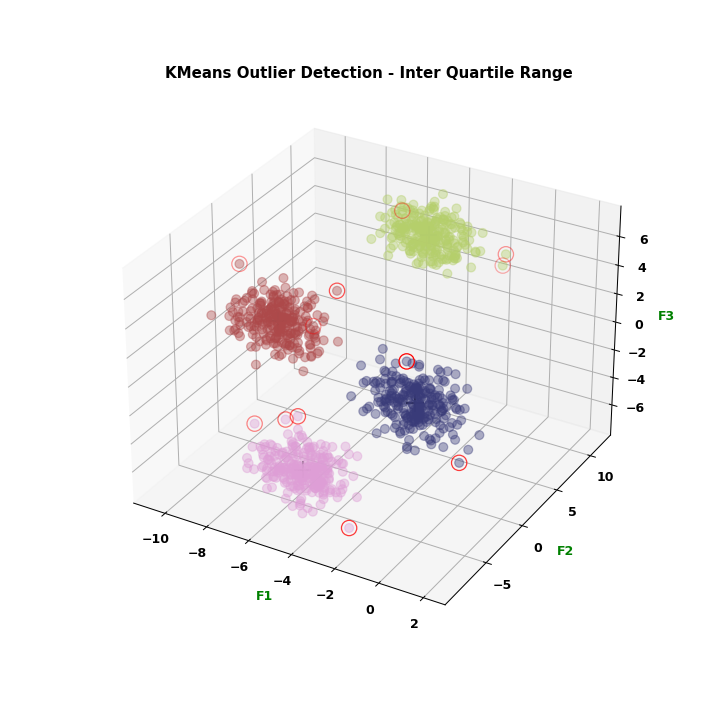

In [26]:
fig = plt.figure(figsize=[8, 8])
ax = plt.axes(projection='3d')

# Scatter plot each record color coded by class
ax.scatter(xs=kmeans_df.f1,
           ys=kmeans_df.f2,
           zs=kmeans_df.f3,
           c=kmeans_df['class'],
           s=50,
           cmap='tab20b',
           alpha=0.4)

# Scatter plot the centers of the different clusters
ax.scatter(xs=kmeans.cluster_centers_[:, 0],
           ys=kmeans.cluster_centers_[:, 1],
           zs=kmeans.cluster_centers_[:, 2],
           c='k',
           marker='+',
           s=200)

# Scater plot to highlight the outliers
ax.scatter(xs=outliers_iqr.f1, 
           ys=outliers_iqr.f2, 
           zs=outliers_iqr.f3,
           s=150,
           facecolors='none',
           edgecolors='r')


ax.set_title('KMeans Outlier Detection - Inter Quartile Range')
ax.set_xlabel('F1', c='g')
ax.set_ylabel('F2', c='g')
ax.set_zlabel('F3', c='g');

<IPython.core.display.Javascript object>


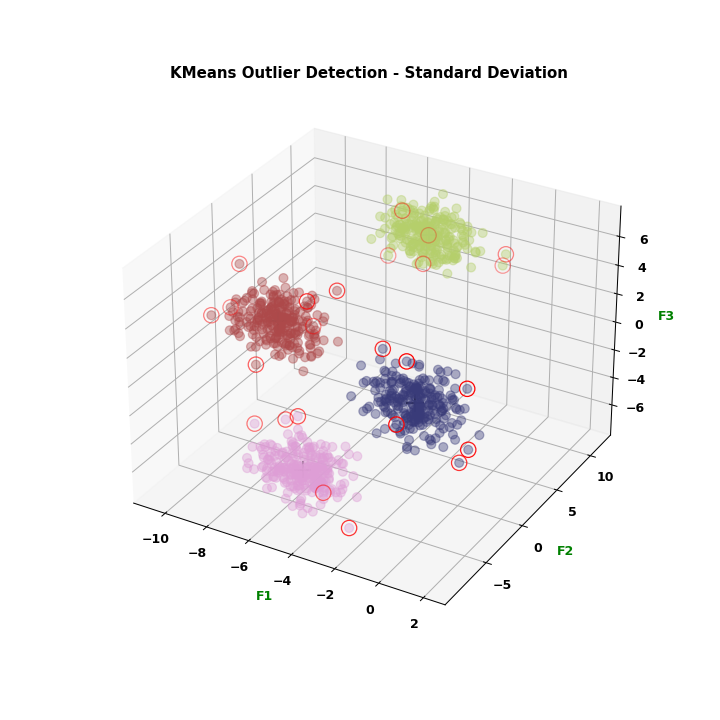

In [27]:
fig = plt.figure(figsize=[8, 8])
ax = plt.axes(projection='3d')

# Scatter plot each record color coded by class
ax.scatter(xs=kmeans_df.f1,
           ys=kmeans_df.f2,
           zs=kmeans_df.f3,
           c=kmeans_df['class'],
           s=50,
           cmap='tab20b',
           alpha=0.4)

# Scatter plot the centers of the different clusters
ax.scatter(xs=kmeans.cluster_centers_[:, 0],
           ys=kmeans.cluster_centers_[:, 1],
           zs=kmeans.cluster_centers_[:, 2],
           c='k',
           marker='+',
           s=200)

# Scater plot to highlight the outliers
ax.scatter(xs=outliers_std.f1, 
           ys=outliers_std.f2, 
           zs=outliers_std.f3,
           s=150,
           facecolors='none',
           edgecolors='r')


ax.set_title('KMeans Outlier Detection - Standard Deviation')
ax.set_xlabel('F1', c='g')
ax.set_ylabel('F2', c='g')
ax.set_zlabel('F3', c='g');